In [1]:
import csv
import subprocess
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import shutil

In [29]:
class Experiment:
    def __init__(self, functions_file, optimization_file, opt_folder, fig_folder):
        self.functions_file = functions_file
        self.optimization_file = optimization_file
        self.functions_param=[]
        self.optimization_param=[]
        
        
        self.f_param_list_function_id=[]
        self.f_param_list_name=[]
        self.f_param_list_range_low=[]
        self.f_param_list_range_high=[]
        self.f_param_list_dimensions_vector=[]
            
        self.opt_param_list_id = []
        self.opt_param_list_name = []
        self.opt_param_list_config_file = []
            
        self.readFunctionsFile()
        self.readOptimizationFile()
        self.opt_folder = opt_folder
        self.fig_folder = fig_folder
        self.solution_file = "solutions.csv"
        self.solution_df = None
        
        #detect os windows or linux
        if os.name == 'nt':
            # Windows
            self.exec = "../bin/release/project.exe"
        else:
            # other (linux)
            self.exec = "../bin/release/project.o"
        
    def readFunctionsFile(self):
        with open(self.functions_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.functions_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.functions_param)):
            self.f_param_list_function_id.append(self.functions_param[i][0]) #function_id
            self.f_param_list_name.append(self.functions_param[i][1]) # function name
            self.f_param_list_range_low.append(self.functions_param[i][2]) # range low
            self.f_param_list_range_high.append(self.functions_param[i][3]) # range high
            self.f_param_list_dimensions_vector.append(self.functions_param[i][4:]) # dimension vector, from 4 to the last element
            
    def readOptimizationFile(self):
        with open(self.optimization_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.optimization_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.optimization_param)):
            self.opt_param_list_id.append(self.optimization_param[i][0]) #opt algorithm id
            self.opt_param_list_name.append(self.optimization_param[i][1]) #algo name
            self.opt_param_list_config_file.append(self.optimization_param[i][2]) # config file
            
    def delete_all_output_files(self):
        files = glob.glob('a*.csv')
        for f in files:
            os.remove(f)
    def moveFileToOutFolder(self, filename):
        shutil.move(filename, self.opt_folder+filename) # move file to out folder
        
    def merge_all_output_files(self):
        files = glob.glob("a*.csv")

        #print(files)
        solutions=[]
        for f in files:
            with open(f) as csvfile:
                read_csv = csv.reader(csvfile, delimiter=',')
                for i,row in enumerate(read_csv):
                    if i != 0: # first row
                        solutions.append(row)
        #print(solutions)
        
        
        with open(self.solution_file, mode='w') as solution_file:
            writer = csv.writer(solution_file, delimiter=',', lineterminator='\n',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['algorithm_id'
                             ,'function_id'
                             ,'n_runs'
                             ,'dimensions'
                             ,'range_low'
                             ,'range_high'
                             ,'mean'
                             ,'std_dev'
                             ,'range'
                             ,'median'
                             ,'time_ms'
                             ,'range_min'
                             ,'range_max'
                            ])
            writer.writerows(solutions)
            
    def plot(self):
        df=pd.read_csv(self.opt_folder +'solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        self.solution_df = df
        
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()
        plt.title('Running time')
        plt.savefig(self.fig_folder+"running_time.png",bbox_inches='tight')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
            ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            ax1.plot(data['algorithm_id'],data['median'],label='median')
            ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            locs = [int(i) for i in self.opt_param_list_id]
            names = self.opt_param_list_name
            ax1.set_xticks(locs, minor=False)
            ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
            #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
            fig.suptitle("f%d : %s"%(id, self.f_param_list_name[id-1]), fontsize=15)
            #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
            #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax1.legend()
            ax1.set_xlabel('Algorithm')
            ax1.set_ylabel('Cost')
            ax1.grid()

            ax2.plot(data['algorithm_id'],data['time_ms'])
            ax2.set_ylabel('CPU Total Running time [ms]')
            ax2.set_xlabel('Algorithm')
            ax2.set_xticks(locs, minor=False)
            ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
            ax2.grid()
            plt.savefig(self.fig_folder + "f"+str(id)+".png",bbox_inches='tight')

        
    # run all the algorithm, 18 functions in the same time, using many CPU
    # may cause some problem with CPU clock() time... which register the cpu time of whole program
    # it seems that python is a program which call many subprocess using Popen. As a result, all the subprocess are
    # accessing to the same clock?
    def run(self, n_runs):
        
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.Popen([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            # wait every process to finish
            for p in process_list:
                p.wait()
            print("----finished----alg: %d"%k)
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    # run all the algorithm in sequence one function after another only only 1 CPU
    def runOneByOne(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.run([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            print("----finished----alg: %d"%k)
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    def runAllLinux(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    
                    command_str =  [self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]]
                    command_str = ' '.join(command_str)
                    os.system(command_str +' &') # execute in background

            print("----running---alg: %d"%k)
            print("the files should be collected manually using collectFiles()")
        

        
    def collectFiles(self):
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
        

In [230]:
test = Experiment("../config/function_list.csv", # function config file
                  "../config/optimization_alg_list.csv", #optimization algorithm config file
                  "../out/optimization/", # output folder for the result
                  "../out/figures/" # output folder for the figures
                 ) 

In [231]:
test.run(10) # n runs in parallel (the cpu time might not be trustful)
#test.runOneByOne(1)

----finished----alg: 0
----finished----alg: 1
----finished----alg: 2
----finished----alg: 3
----finished----alg: 4
----finished----alg: 5
----finished----alg: 6
----finished----alg: 7
----finished----alg: 8
----finished----alg: 9
----finished----alg: 10
----finished----alg: 11
----finished----alg: 12


In [102]:
#test.runAllLinux(50)

In [103]:
#test.collectFiles()

In [233]:
# Tuning
#Calibration 
df=pd.read_csv('../out/optimization/solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
#tuning function 
df_f=df[df['function_id']==1]


pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.3f}'.format
#df
df_f

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,1182.920,249.675,758.213,1150.900,16160,800.329,1558.540
72,1,1,10,30,-512,512.000,2695.790,316.635,1107.520,2766.060,14293,2104.830,3212.350
90,2,1,10,30,-512,512.000,3276.460,269.835,995.574,3243.810,13747,2609.700,3605.270
108,3,1,10,30,-512,512.000,6381.810,362.902,1252.110,6484.340,15532,5564.320,6816.430
126,4,1,10,30,-512,512.000,3342.310,683.479,2205.470,3414.920,19755,2235.290,4440.760
144,5,1,10,30,-512,512.000,1860.220,289.111,940.688,1938.640,16482,1328.200,2268.890
162,6,1,10,30,-512,512.000,2097.740,328.537,1224.090,2028.520,16820,1615.030,2839.110
180,7,1,10,30,-512,512.000,7104.320,341.828,1206.820,7222.730,15024,6302.070,7508.890
198,8,1,10,30,-512,512.000,6675.200,980.298,3771.630,6862.010,13940,4303.480,8075.100
216,9,1,10,30,-512,512.000,2102.690,253.535,912.027,2088.630,17982,1708.300,2620.330


pd.options.display.float_format = '{:.3f}'.format
df

plt.plot(df_f['algorithm_id'],df_f['mean'])
plt.grid()
plt.xticks(df_f['algorithm_id'])

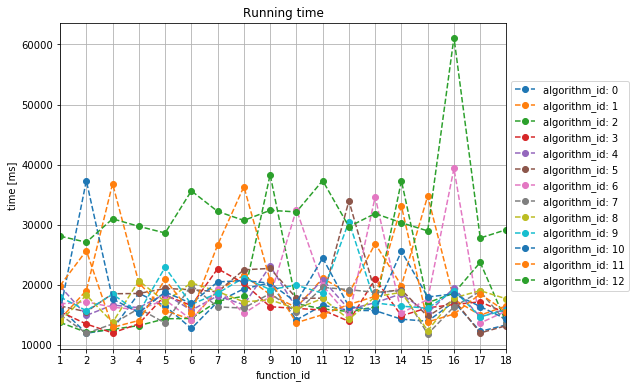

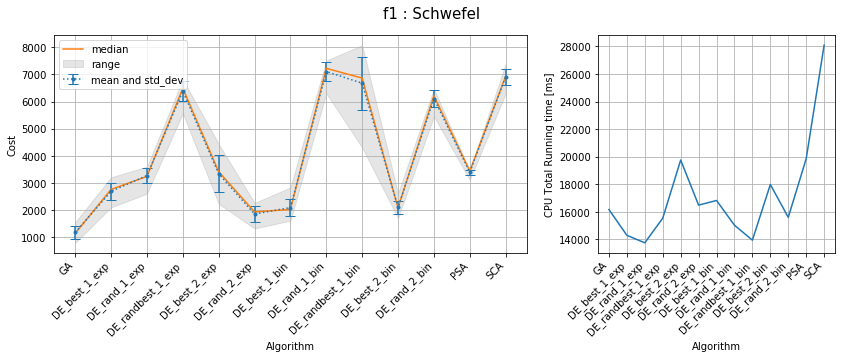

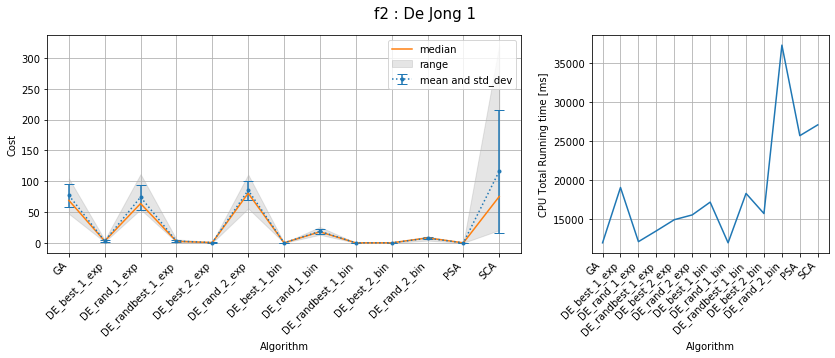

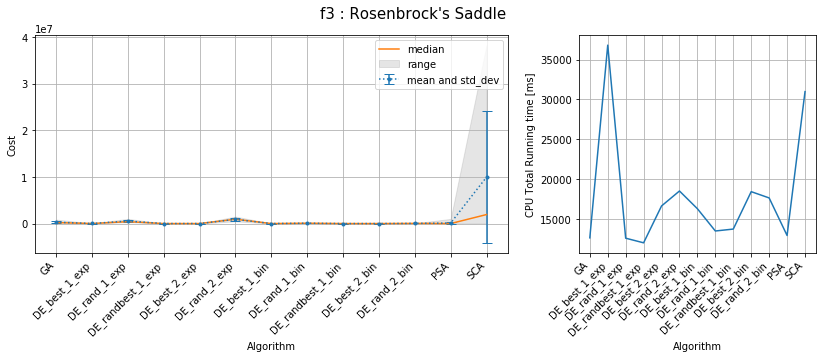

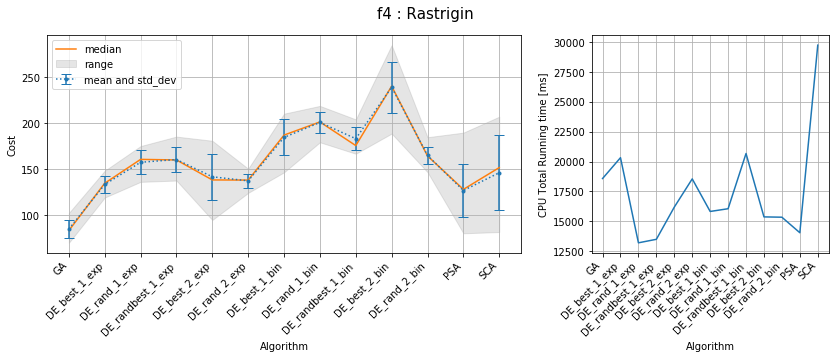

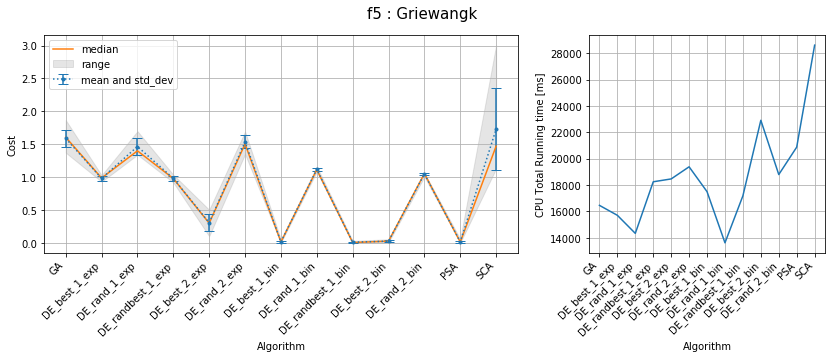

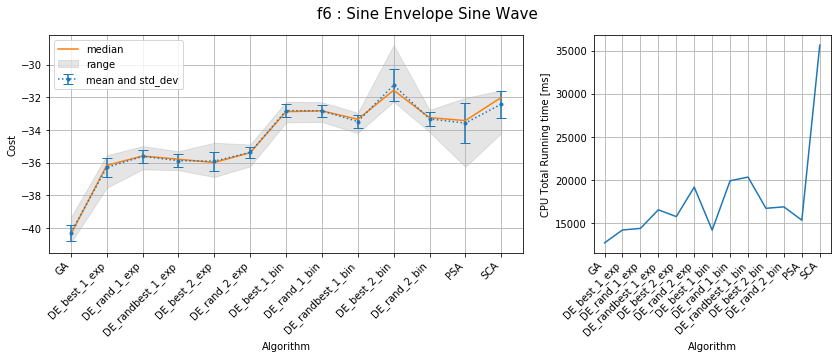

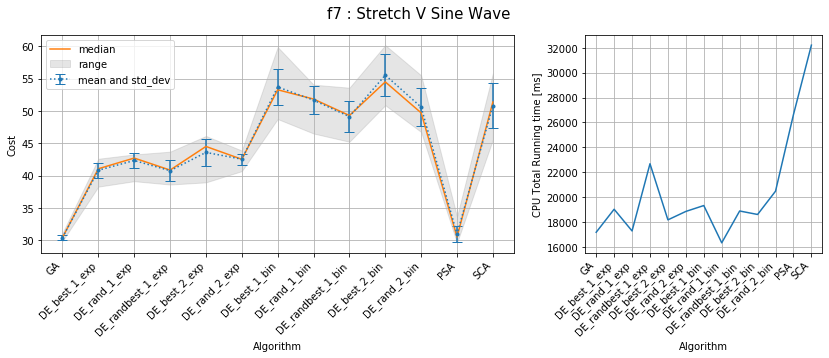

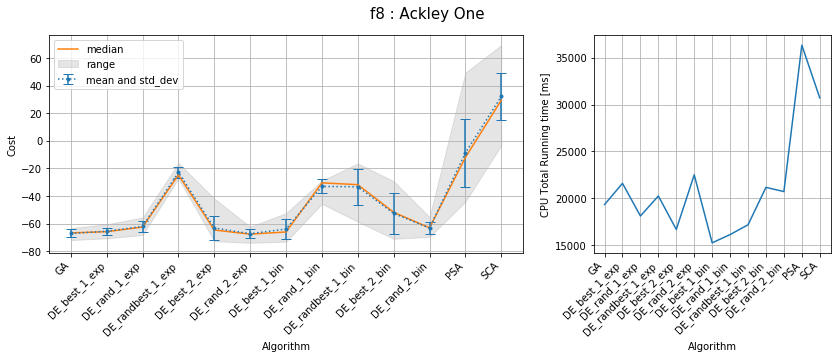

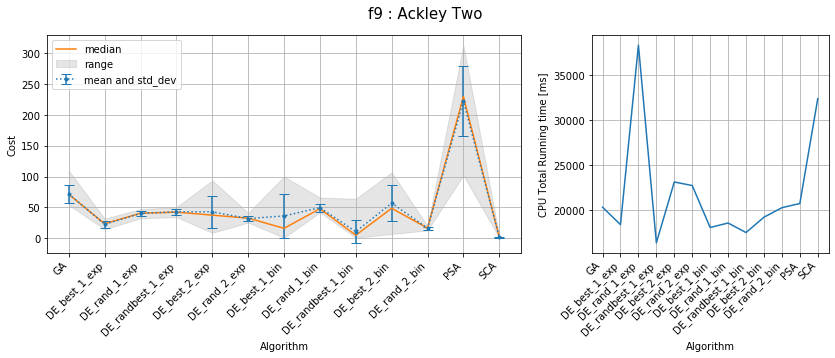

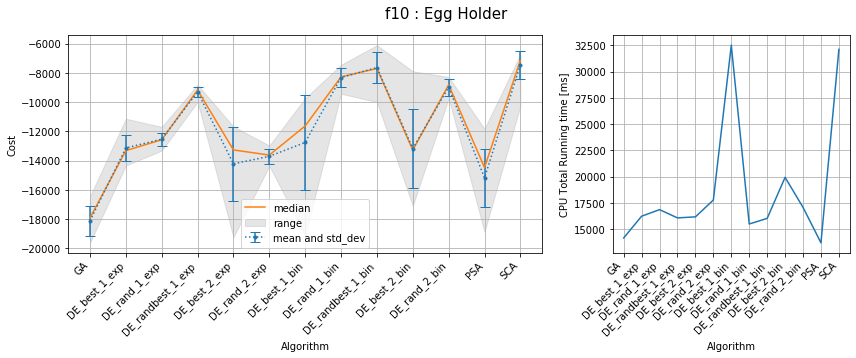

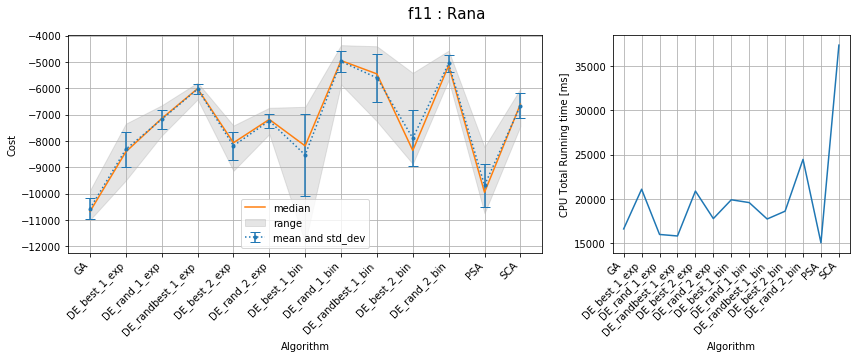

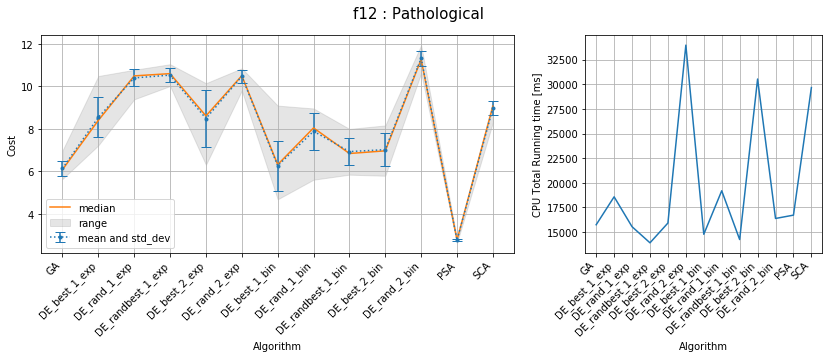

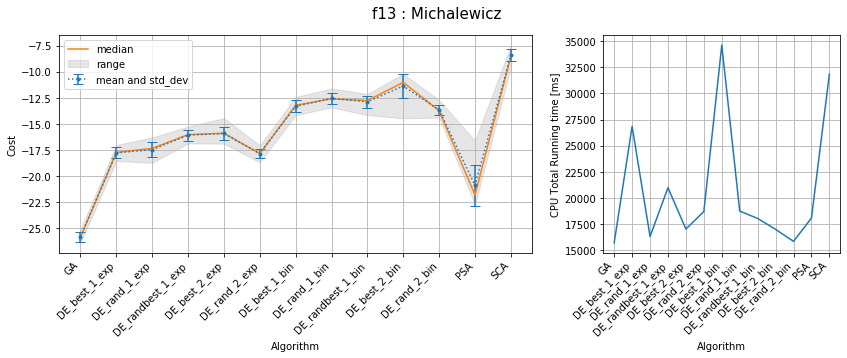

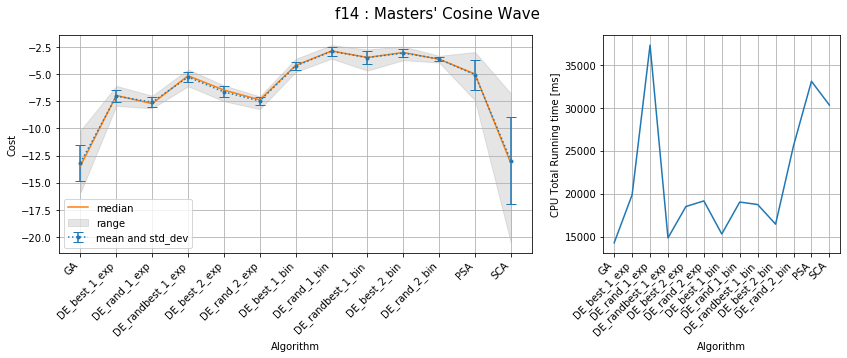

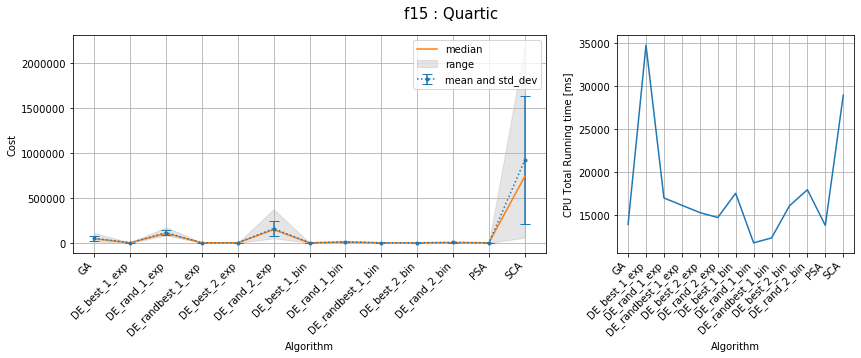

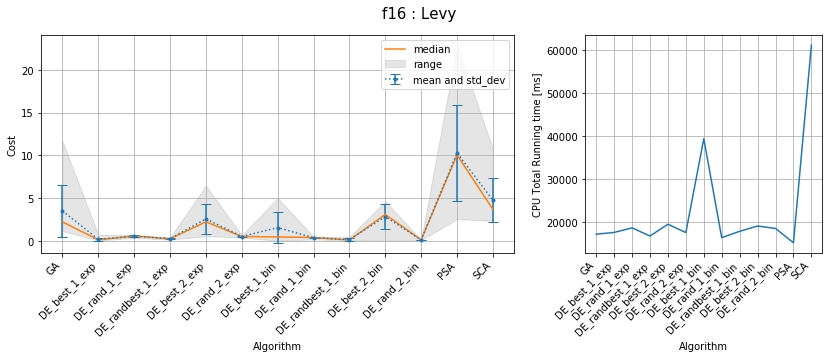

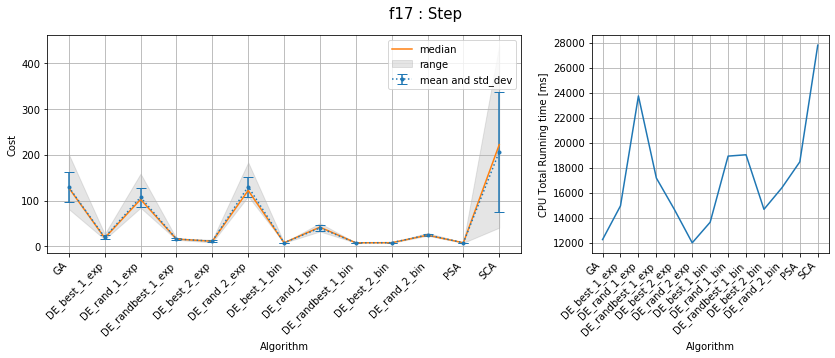

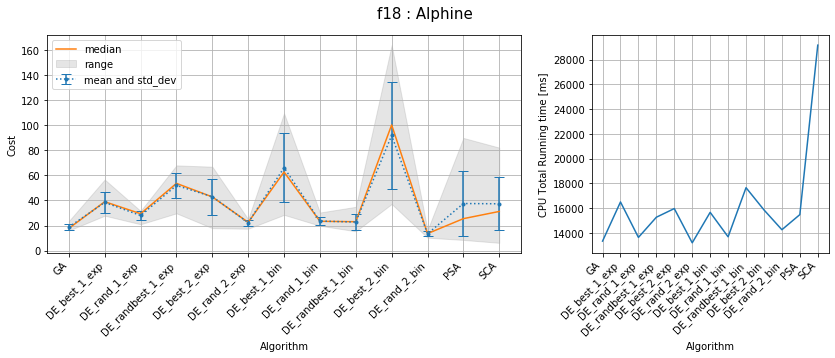

In [234]:
test.plot()

In [235]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
test.solution_df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,1182.920,249.675,758.213,1150.900,16160,800.329,1558.540
10,0,2,10,30,-100,100.000,77.108,18.665,57.434,68.943,11931,47.175,104.608
11,0,3,10,30,-100,100.000,292405.000,197143.000,683484.000,215381.000,12628,163384.000,846868.000
12,0,4,10,30,-30,30.000,85.266,9.794,32.424,83.572,18583,70.261,102.685
13,0,5,10,30,-500,500.000,1.587,0.129,0.496,1.605,16465,1.371,1.867
14,0,6,10,30,-30,30.000,-40.292,0.490,1.555,-40.393,12726,-40.914,-39.359
15,0,7,10,30,-30,30.000,30.427,0.417,1.236,30.417,17167,29.878,31.114
16,0,8,10,30,-32,32.000,-67.177,2.914,8.722,-66.778,19329,-71.991,-63.269
17,0,9,10,30,-32,32.000,71.441,15.079,55.749,70.874,20314,53.590,109.340
1,0,10,10,30,-500,500.000,-18125.700,1013.760,3179.040,-17930.400,14154,-19631.800,-16452.800


In [236]:
df = test.solution_df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,1182.920,249.675,758.213,1150.900,16160,800.329,1558.540
72,1,1,10,30,-512,512.000,2695.790,316.635,1107.520,2766.060,14293,2104.830,3212.350
90,2,1,10,30,-512,512.000,3276.460,269.835,995.574,3243.810,13747,2609.700,3605.270
108,3,1,10,30,-512,512.000,6381.810,362.902,1252.110,6484.340,15532,5564.320,6816.430
126,4,1,10,30,-512,512.000,3342.310,683.479,2205.470,3414.920,19755,2235.290,4440.760
144,5,1,10,30,-512,512.000,1860.220,289.111,940.688,1938.640,16482,1328.200,2268.890
162,6,1,10,30,-512,512.000,2097.740,328.537,1224.090,2028.520,16820,1615.030,2839.110
180,7,1,10,30,-512,512.000,7104.320,341.828,1206.820,7222.730,15024,6302.070,7508.890
198,8,1,10,30,-512,512.000,6675.200,980.298,3771.630,6862.010,13940,4303.480,8075.100
216,9,1,10,30,-512,512.000,2102.690,253.535,912.027,2088.630,17982,1708.300,2620.330


# Read solution.csv, generate plot and latex report

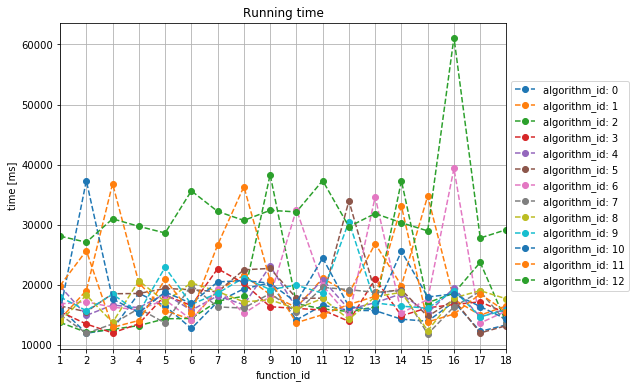

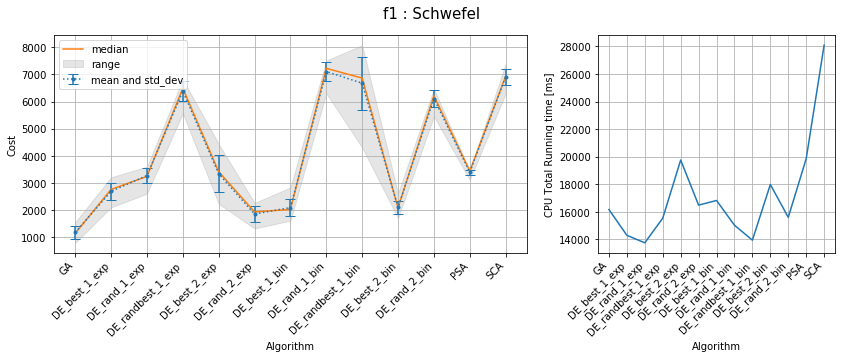

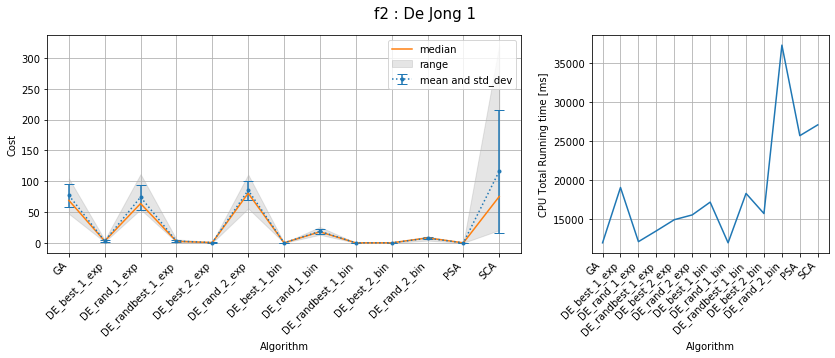

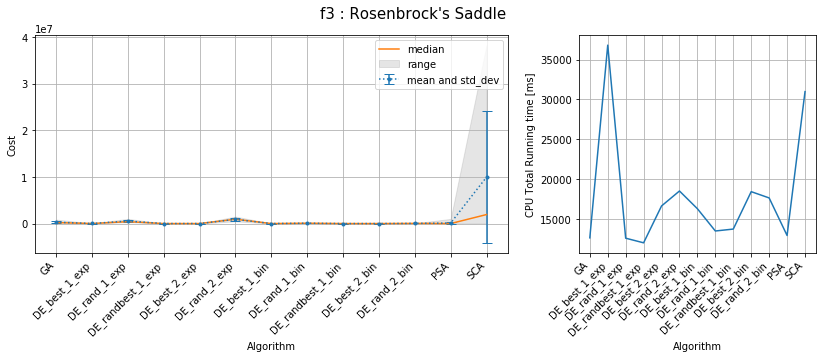

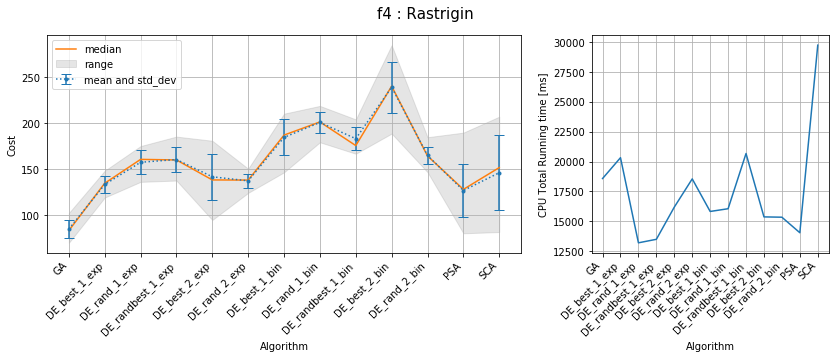

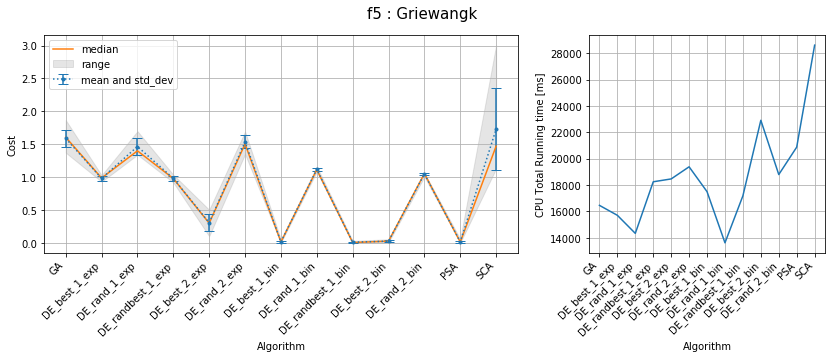

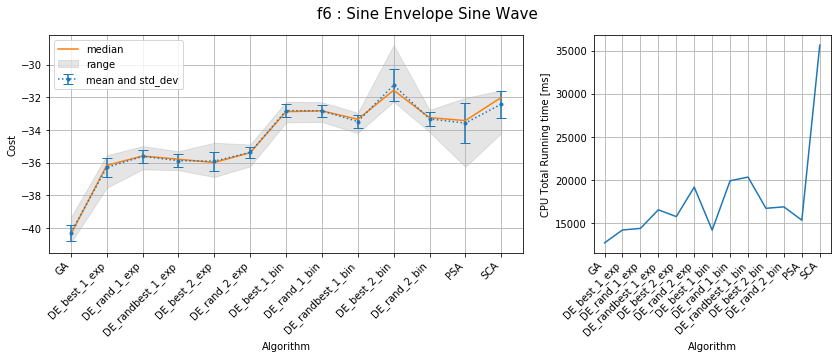

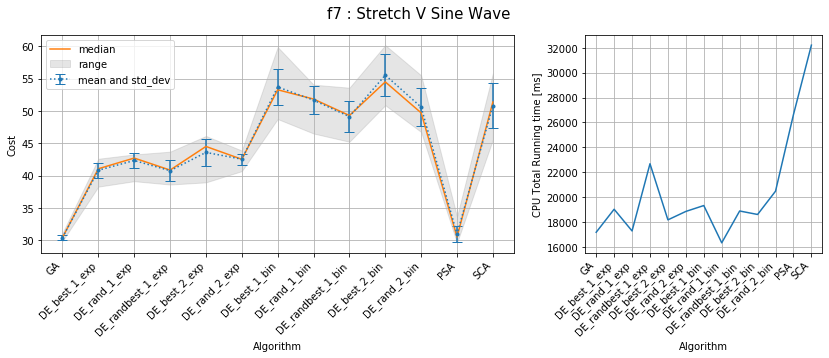

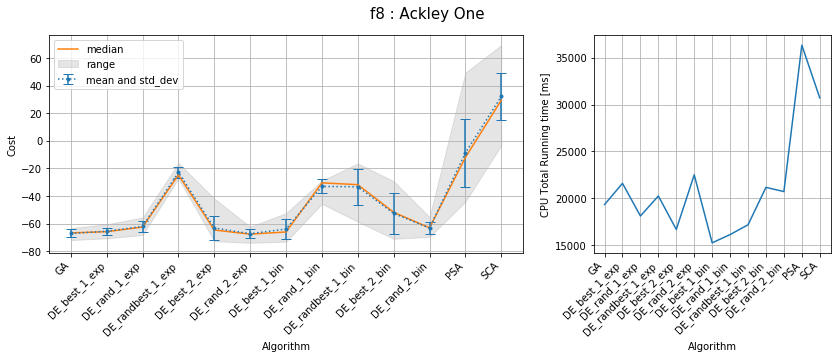

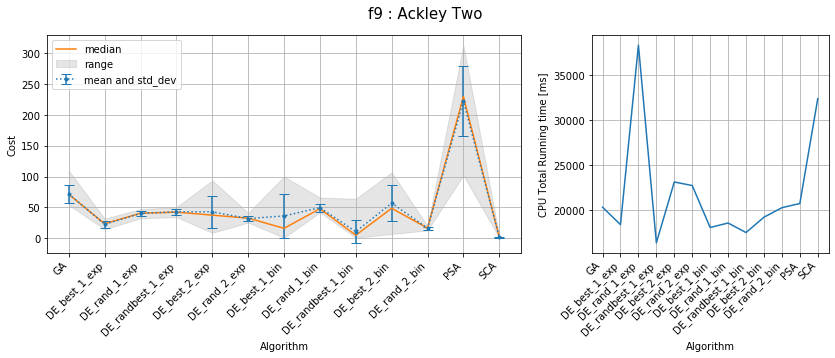

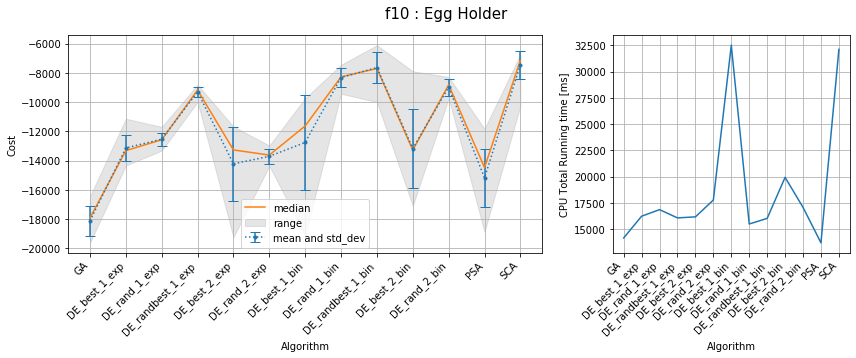

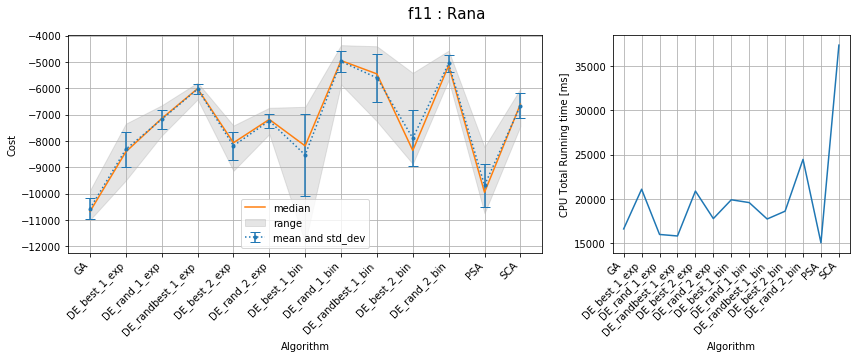

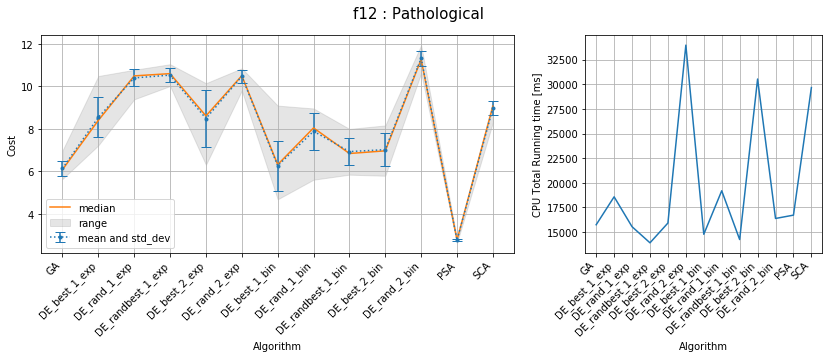

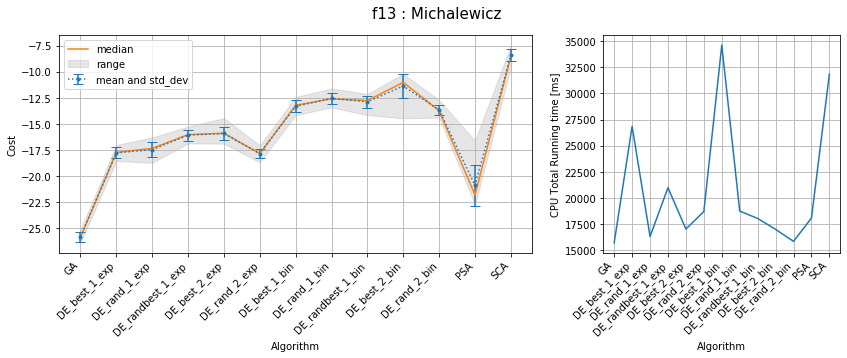

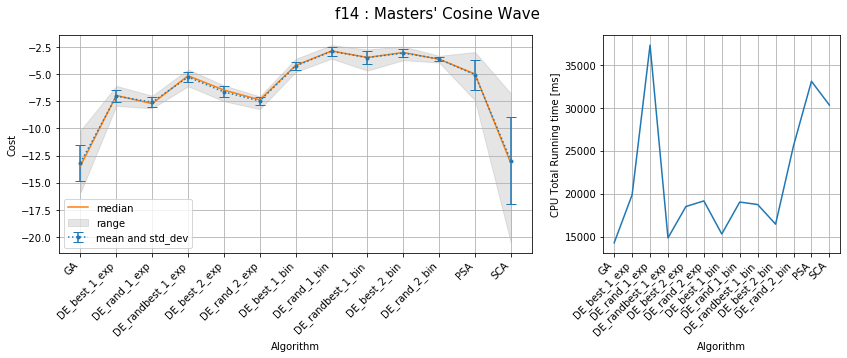

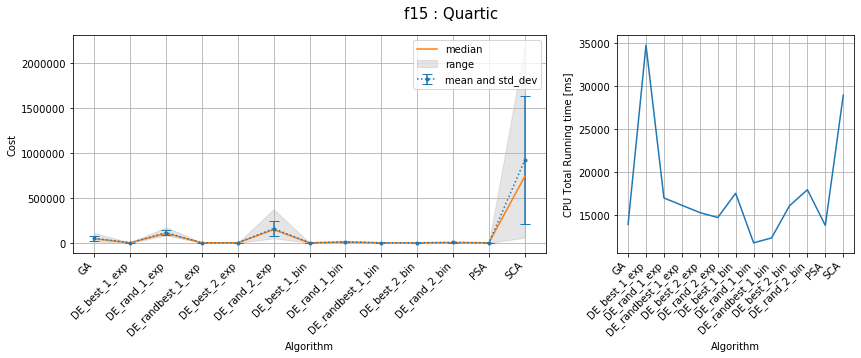

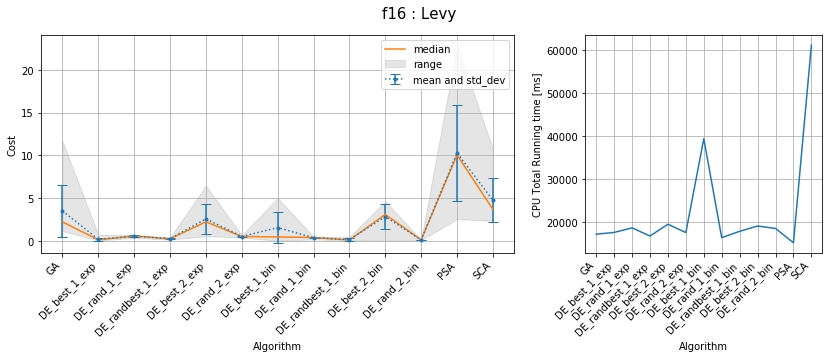

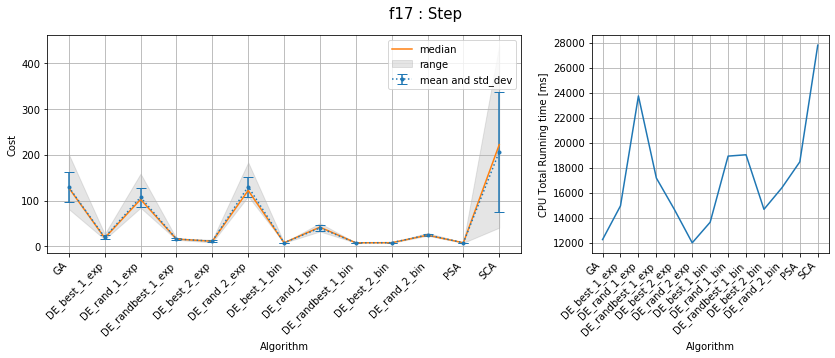

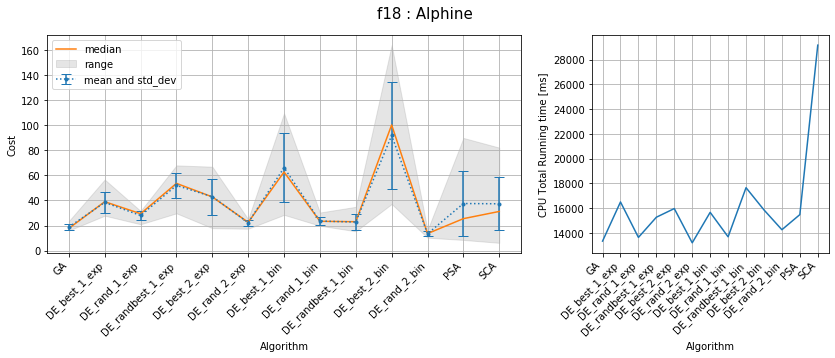

In [237]:
df=pd.read_csv("../out/optimization/"+'solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)


#-----------plot running time
fig, ax = plt.subplots(figsize=(8,6))
for label, data in df.groupby('algorithm_id'):
    data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
plt.ylabel('time [ms]')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('Running time')
#plt.savefig("running_time.png",bbox_inches='tight')


#---------plot statistics
for id, data in df.groupby('function_id'):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
    ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
    ax1.plot(data['algorithm_id'],data['median'],label='median')
    ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
    locs = [int(i) for i in test.opt_param_list_id]
    names = test.opt_param_list_name
    ax1.set_xticks(locs, minor=False)
    ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
    #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
    fig.suptitle("f%d : %s"%(id, test.f_param_list_name[id-1]), fontsize=15)
    #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.legend()
    ax1.set_xlabel('Algorithm')
    ax1.set_ylabel('Cost')
    ax1.grid()
    
    ax2.plot(data['algorithm_id'],data['time_ms'])
    ax2.set_ylabel('CPU Total Running time [ms]')
    ax2.set_xlabel('Algorithm')
    ax2.set_xticks(locs, minor=False)
    ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
    ax2.grid()
    #plt.savefig("f"+str(id)+".png",bbox_inches='tight')


In [175]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,1146.570,360.824,1330.950,1186.340,1360,326.523,1657.470
10,0,2,10,30,-100,100.000,85.204,20.505,63.335,82.999,490,60.843,124.179
11,0,3,10,30,-100,100.000,401324.000,359514.000,1285670.000,252334.000,548,93912.100,1379590.000
12,0,4,10,30,-30,30.000,77.539,12.787,37.351,83.016,1106,55.992,93.343
13,0,5,10,30,-500,500.000,1.587,0.174,0.506,1.561,1283,1.368,1.874
14,0,6,10,30,-30,30.000,-40.168,0.679,2.375,-40.133,1135,-41.279,-38.904
15,0,7,10,30,-30,30.000,30.682,0.378,1.120,30.601,3222,30.154,31.274
16,0,8,10,30,-32,32.000,-67.475,3.364,12.067,-67.627,1813,-72.588,-60.521
17,0,9,10,30,-32,32.000,63.707,4.698,18.618,63.580,3154,55.978,74.596
1,0,10,10,30,-500,500.000,-18724.000,553.787,1702.200,-18500.500,2011,-19736.400,-18034.200


## support codes for latex report generation

In [238]:
# https://stats.stackexchange.com/questions/124096/two-samples-z-test-in-python
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(z, 3), round(pval, 4)

z, p = twoSampZ(1330, 1350, 0, 388.5, 190.64, 50, 50)

In [239]:
df_s = df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df_s
n_sample = df_s["n_runs"].iloc[0]

# print the table and export to latex

In [240]:
def print_latex_function(function_id):
    df_fx = df_s[df_s["function_id"]==function_id] # dataframe of function_id
    
    # get name of the algorithms
    alg_id = [str(i) for i in df_fx["algorithm_id"].values.tolist()] # convert algorithm id to string
    alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
    alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
    # insert algorithms name to the dataframe
    df_fx = df_fx[["mean","std_dev","median","range_min","range_max","time_ms"]]
    df_fx.insert(0,"algorithm",alg_name)
    #display(df_fx)
    
    # get name of the functions
    f_index = test.f_param_list_function_id.index(str(function_id))
    f_name = test.f_param_list_name[f_index]
    
        
    #print subsection 
    print("\\subsection{Function %d: %s}"%(function_id, f_name))
    
    
    #print function
    print("""
    \\begin{figure}[H]
    \\centering
    
    \\includegraphics[width=1\\linewidth]{{"figures/figures - linux 1 cpu/f%d"}.png}
    
    \\caption{Cost and CPU total running time of Function %d: %s} 
    \\label{fig:f%d}
    \\end{figure}
    """%(function_id, function_id, f_name, function_id))


    
    # print latex table
    print("""\\begin{table}[H]
    \\centering
    \\footnotesize""")
    print(df_fx.to_latex(index=False))
    print("""\\caption{Function %d: Statistical Analysis of the Cost} 
    \\end{table}"""%function_id)
    
    
    # Hypothesis testing 
    #find the min beside GA
    #df_ga = df_fx[df_fx["algorithm"]=="GA"]
    #df_fx = df_fx[df_fx["algorithm"]!="GA"]
    min_index = df_fx[['mean']].idxmin()
    df_min = df_fx.loc[min_index] # minimun 
    x1=df_min["mean"].values[0]
    sd1=df_min["std_dev"].values[0]
    
   
    min_latex = df_min["algorithm"].values[0].replace("_","\_")
    print("Best Algorithm: \\\\")
    print("\\textbf{%s}, Cost (mean): %f\\\\"%(min_latex, x1))
        
    # save the good algorithms after the hypothesis testing
    good_alg = []
    # compare everyone with the best
    already_printed=False
    for index, row in df_fx.iterrows():
        if index != min_index.values[0]: #exclude compare with itself
  
            #get name
            current_latex = row["algorithm"].replace("_","\_")
            
            #preparing data for z-test (two sample)
            x2=row["mean"]
            sd2=row["std_dev"]

            z,p = twoSampZ(x1,x2,0,sd1,sd2,n_sample,n_sample)

            

            if(p>0.05):
                if not already_printed:
                    print("\\noindent")
                    print("\\textbf{Two-Sample Z-Test Hypothesis Testing: }")
                    print("confidence interval = 95\%\\\\")
                    already_printed = True
          
                print("\\textbf{%s}, Cost (mean): %f"%(current_latex, x2))
                print(" P value: %f   "%p)
                print("\\textbf{the cost of %s is equal to the cost of %s}.\\\\"%(current_latex, min_latex))
                good_alg.append(row["algorithm"])
    
    return good_alg

print_latex_function(8)

\subsection{Function 8: Ackley One}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures - linux 1 cpu/f8"}.png}
    
    \caption{Cost and CPU total running time of Function 8: Ackley One} 
    \label{fig:f8}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &    mean &  std\_dev &  median &  range\_min &  range\_max &  time\_ms \\
\midrule
                GA & -67.177 &    2.914 & -66.778 &    -71.991 &    -63.269 &    19329 \\
     DE\_best\_1\_exp & -65.600 &    2.684 & -65.879 &    -70.689 &    -60.529 &    21591 \\
     DE\_rand\_1\_exp & -62.070 &    3.901 & -62.547 &    -68.277 &    -55.613 &    18108 \\
 DE\_randbest\_1\_exp & -22.917 &    3.998 & -24.746 &    -27.294 &    -16.119 &    20242 \\
     DE\_best\_2\_exp & -63.194 &    8.771 & -64.674 &    -72.775 &    -41.871 &    16671 \\
     DE\_rand\_2\_exp & -67.353 &    3.380 & -67.693 &    -73.965 &    

['GA', 'DE_best_1_exp', 'DE_best_2_exp', 'DE_best_1_bin']

## Print latex

In [241]:
function_list = df_s["function_id"].unique()
good_algs = []
for i in function_list:
    good_algs.append(print_latex_function(i))

\subsection{Function 1: Schwefel}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures - linux 1 cpu/f1"}.png}
    
    \caption{Cost and CPU total running time of Function 1: Schwefel} 
    \label{fig:f1}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &     mean &  std\_dev &   median &  range\_min &  range\_max &  time\_ms \\
\midrule
                GA & 1182.920 &  249.675 & 1150.900 &    800.329 &   1558.540 &    16160 \\
     DE\_best\_1\_exp & 2695.790 &  316.635 & 2766.060 &   2104.830 &   3212.350 &    14293 \\
     DE\_rand\_1\_exp & 3276.460 &  269.835 & 3243.810 &   2609.700 &   3605.270 &    13747 \\
 DE\_randbest\_1\_exp & 6381.810 &  362.902 & 6484.340 &   5564.320 &   6816.430 &    15532 \\
     DE\_best\_2\_exp & 3342.310 &  683.479 & 3414.920 &   2235.290 &   4440.760 &    19755 \\
     DE\_rand\_2\_exp & 1860.220 &  289.111 & 1938.640 &   1328

## get algorithms with similar result comparing to the best

In [249]:
good_algs_s = [", ".join(i) for i in good_algs]
good_algs_s

['',
 '',
 'DE_best_1_bin, DE_randbest_1_bin, PSA',
 '',
 'DE_best_1_bin, PSA',
 '',
 'PSA',
 'GA, DE_best_1_exp, DE_best_2_exp, DE_best_1_bin',
 'DE_randbest_1_bin',
 '',
 '',
 '',
 '',
 'SCA',
 'DE_randbest_1_exp, DE_randbest_1_bin, DE_best_2_bin',
 'DE_best_1_exp, DE_randbest_1_bin',
 'DE_best_1_bin, PSA',
 '']

In [250]:
df_similar=pd.DataFrame(list(zip(function_list,good_algs_s)), columns = ['function_id','similar_result'])

# print summary table

In [244]:
df_summary = df.sort_values(by=['algorithm_id','function_id'], inplace = False)
df_summary

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,1182.920,249.675,758.213,1150.900,16160,800.329,1558.540
10,0,2,10,30,-100,100.000,77.108,18.665,57.434,68.943,11931,47.175,104.608
11,0,3,10,30,-100,100.000,292405.000,197143.000,683484.000,215381.000,12628,163384.000,846868.000
12,0,4,10,30,-30,30.000,85.266,9.794,32.424,83.572,18583,70.261,102.685
13,0,5,10,30,-500,500.000,1.587,0.129,0.496,1.605,16465,1.371,1.867
14,0,6,10,30,-30,30.000,-40.292,0.490,1.555,-40.393,12726,-40.914,-39.359
15,0,7,10,30,-30,30.000,30.427,0.417,1.236,30.417,17167,29.878,31.114
16,0,8,10,30,-32,32.000,-67.177,2.914,8.722,-66.778,19329,-71.991,-63.269
17,0,9,10,30,-32,32.000,71.441,15.079,55.749,70.874,20314,53.590,109.340
1,0,10,10,30,-500,500.000,-18125.700,1013.760,3179.040,-17930.400,14154,-19631.800,-16452.800


In [245]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = alg_name[int(label)]
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
display(df_result)
print(df_result.to_latex(index=False))

c:\users\chao_\miniconda3\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin,PSA,SCA
0,1,1182.920,2695.790,3276.460,6381.810,3342.310,1860.220,2097.740,7104.320,6675.200,2102.690,6111.000,3398.790,6909.700
1,2,77.108,2.908,74.250,2.820,0.444,85.395,0.004,18.719,0.002,0.007,7.535,0.001,116.418
2,3,292405.000,12233.700,532153.000,2290.640,3504.730,898544.000,1175.660,76296.200,274.127,250.932,34226.900,100259.000,9955200.000
3,4,85.266,133.665,157.810,160.794,142.040,137.623,184.883,201.147,183.469,239.424,165.237,127.125,146.471
4,5,1.587,0.979,1.464,0.980,0.306,1.534,0.014,1.117,0.009,0.024,1.047,0.015,1.728
5,6,-40.292,-36.295,-35.618,-35.882,-35.911,-35.379,-32.814,-32.828,-33.483,-31.251,-33.328,-33.578,-32.419
6,7,30.427,40.835,42.338,40.759,43.587,42.542,53.712,51.670,49.124,55.543,50.593,30.954,50.838
7,8,-67.177,-65.600,-62.070,-22.917,-63.194,-67.353,-63.980,-33.086,-33.379,-52.663,-63.249,-8.812,32.068
8,9,71.441,22.436,40.002,42.554,42.621,31.691,35.954,49.372,10.460,56.699,16.029,222.576,1.593
9,10,-18125.700,-13138.200,-12533.200,-9291.070,-14222.500,-13707.100,-12758.200,-8311.820,-7631.020,-13173.900,-8976.180,-15185.600,-7427.270


\begin{tabular}{rrrrrrrrrrrrrr}
\toprule
 function\_id &         GA &  DE\_best\_1\_exp &  DE\_rand\_1\_exp &  DE\_randbest\_1\_exp &  DE\_best\_2\_exp &  DE\_rand\_2\_exp &  DE\_best\_1\_bin &  DE\_rand\_1\_bin &  DE\_randbest\_1\_bin &  DE\_best\_2\_bin &  DE\_rand\_2\_bin &        PSA &         SCA \\
\midrule
           1 &   1182.920 &       2695.790 &       3276.460 &           6381.810 &       3342.310 &       1860.220 &       2097.740 &       7104.320 &           6675.200 &       2102.690 &       6111.000 &   3398.790 &    6909.700 \\
           2 &     77.108 &          2.908 &         74.250 &              2.820 &          0.444 &         85.395 &          0.004 &         18.719 &              0.002 &          0.007 &          7.535 &      0.001 &     116.418 \\
           3 & 292405.000 &      12233.700 &     532153.000 &           2290.640 &       3504.730 &     898544.000 &       1175.660 &      76296.200 &            274.127 &        250.932 &      34226.900 & 100259.000 

In [246]:
df_result

,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin,PSA,SCA
0,1,1182.920,2695.790,3276.460,6381.810,3342.310,1860.220,2097.740,7104.320,6675.200,2102.690,6111.000,3398.790,6909.700
1,2,77.108,2.908,74.250,2.820,0.444,85.395,0.004,18.719,0.002,0.007,7.535,0.001,116.418
2,3,292405.000,12233.700,532153.000,2290.640,3504.730,898544.000,1175.660,76296.200,274.127,250.932,34226.900,100259.000,9955200.000
3,4,85.266,133.665,157.810,160.794,142.040,137.623,184.883,201.147,183.469,239.424,165.237,127.125,146.471
4,5,1.587,0.979,1.464,0.980,0.306,1.534,0.014,1.117,0.009,0.024,1.047,0.015,1.728
5,6,-40.292,-36.295,-35.618,-35.882,-35.911,-35.379,-32.814,-32.828,-33.483,-31.251,-33.328,-33.578,-32.419
6,7,30.427,40.835,42.338,40.759,43.587,42.542,53.712,51.670,49.124,55.543,50.593,30.954,50.838
7,8,-67.177,-65.600,-62.070,-22.917,-63.194,-67.353,-63.980,-33.086,-33.379,-52.663,-63.249,-8.812,32.068
8,9,71.441,22.436,40.002,42.554,42.621,31.691,35.954,49.372,10.460,56.699,16.029,222.576,1.593
9,10,-18125.700,-13138.200,-12533.200,-9291.070,-14222.500,-13707.100,-12758.200,-8311.820,-7631.020,-13173.900,-8976.180,-15185.600,-7427.270


## get best cost without time

In [251]:
df_best = df_result[["function_id"]]
df_best["best_algorithm"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,best_algorithm,best_cost
0,1,GA,1182.920
1,2,PSA,0.001
2,3,DE_best_2_bin,250.932
3,4,GA,85.266
4,5,DE_randbest_1_bin,0.009
5,6,GA,-40.292
6,7,GA,30.427
7,8,DE_rand_2_exp,-67.353
8,9,SCA,1.593
9,10,GA,-18125.700


In [252]:
df_best.merge(df_similar, on=["function_id"], how='left') 

,function_id,best_algorithm,best_cost,similar_result
0,1,GA,1182.920,
1,2,PSA,0.001,
2,3,DE_best_2_bin,250.932,"DE_best_1_bin, DE_randbest_1_bin, PSA"
3,4,GA,85.266,
4,5,DE_randbest_1_bin,0.009,"DE_best_1_bin, PSA"
5,6,GA,-40.292,
6,7,GA,30.427,PSA
7,8,DE_rand_2_exp,-67.353,"GA, DE_best_1_exp, DE_best_2_exp, DE_best_1_bin"
8,9,SCA,1.593,DE_randbest_1_bin
9,10,GA,-18125.700,


## get best cost with time

In [70]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = int(label)
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
#display(df_result)
#print(df_result.to_latex(index=False))

In [71]:
df_best = df_result[["function_id"]]
df_best["algorithm_id"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
temp = df[["algorithm_id", "function_id", "time_ms"]]
df_best = df_best.merge(temp, on=["function_id","algorithm_id"], how='left') 
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,algorithm_id,best_cost,time_ms
0,1,0,1330.170,2158.370
1,2,8,0.002,1249.120
2,3,6,520.354,1260.940
3,4,0,-67715.300,2311.080
4,5,8,0.011,2978.360
5,6,0,-40.070,2505.260
6,7,0,30.665,4661.080
7,8,0,-68.615,3126.870
8,9,8,8.953,4897.940
9,10,0,-18226.300,3839.400
